In [1]:
# Enable inline Matplotlib
%matplotlib inline

# Imports
# JSON
import json

# NumPy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Pandas
import pandas as pd

#scikit-learn
from sklearn.linear_model import LinearRegression

In [85]:
def log_loader(file_path, target_beacons, distance):
    with open(file_path) as json_file:
        log = json.load(json_file)
        log['target_beacons'] = target_beacons
        log['distance'] = distance   
        return log
    
def convert_logs_to_dataframe(logs, beacons_inactivity_timer=5000):
    dfs = []
    for log in logs:
        table = []
        #print('Log', log['name'], 'which started at:', log['creationTimestamp'])
        #print('Focusing on:')
        for beacon in log['target_beacons']:
            #print('UUID:', beacon['uuid'], 'Major:', beacon['major'], 'Minor:', beacon['minor'])
            for entries in log['sessions'].values():
                for entry in entries:
                    #print(entry)
                    reading = entry['reading']
                    if reading['type'] == 'iBeacon' and reading['values'][0] == beacon['uuid']\
                    and reading['values'][1] == beacon['major'] and reading['values'][2] == beacon['minor']:
                        #print(reading)
                        table.append([log['name'], pd.to_datetime(log['timestamp'], unit='ms'),
                                      entry['id'], reading['id'], reading['type'], str(reading['values']),
                                      reading['values'][0], reading['values'][1], reading['values'][2],
                                      reading['txPower'], reading['rssi'],
                                      pd.to_datetime(reading['timestamp'], unit='ms'),
                                      reading['avgRssi'], log['distance']])
        df = pd.DataFrame(table, columns=['filename', 'creationTimestamp', 'entry', 'id', 'type', 'values',
                                          'uuid', 'major', 'minor', 'txPower', 'rssi', 'timestamp',
                                          'avgRssi', 'distance'])
        df['rolling_mean_rssi'] = df[['timestamp', 'rssi']].rolling(str(beacons_inactivity_timer)+'ms', on='timestamp').mean()['rssi']
        df['rssi_mean'] = df['rssi'].mean()
        df['weight'] = (df['rssi_mean'].abs() - (df['rssi'] - df['rssi_mean']).abs())/df['rssi_mean'].abs()
        
        #ts = df['timestamp'].iloc[0];
        #df = df[df.timestamp > ts+pd.Timedelta(milliseconds=beacons_inactivity_timer)]
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)[['timestamp','values', 'distance', 'rssi', 'rolling_mean_rssi', 'avgRssi', 'rssi_mean',  'weight']]

In [86]:
# Load Data
distances = np.linspace(0,10,21)
collections = {
    'laptop': {
        'distances': distances,
        'targets': [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 102 }]
    },
    'smartphone':  {
        'distances': distances,
        'targets': [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 101 }]
    }
}

tables = {}
for name, device in collections.items():
    logs = []
    for d in device['distances']:
        logs.append(log_loader('data/beacons/'+name+'/beacons-'+str(d)+'.json', device['targets'], d))
    tables[name] = convert_logs_to_dataframe(logs)
    tables[name]['device'] = name
    
data = pd.concat(tables.values(), ignore_index=True)

# Old variables for compatibility with old plots below
df_laptop = dfs['laptop']
df_smartphone = dfs['smartphone']
df_all = data
display(df_all)

,timestamp,values,distance,rssi,rolling_mean_rssi,avgRssi,rssi_mean,weight,device
0,2019-10-03 12:57:22.098,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-56.000000,-56.000000,-52.411765,0.931538,laptop
1,2019-10-03 12:57:22.230,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-50,-53.000000,-53.000000,-52.411765,0.953984,laptop
2,2019-10-03 12:57:22.515,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.666667,-52.666667,-52.411765,0.992144,laptop
3,2019-10-03 12:57:22.922,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.750000,-51.750000,-52.411765,0.934905,laptop
4,2019-10-03 12:57:23.059,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.000000,-52.000000,-52.411765,0.988777,laptop
...,...,...,...,...,...,...,...,...,...
8149,2019-10-03 13:46:35.820,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",10.0,-78,-71.454545,-70.676471,-74.416667,0.951848,smartphone
8150,2019-10-03 13:46:35.822,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",10.0,-78,-72.000000,-70.676471,-74.416667,0.951848,smartphone
8151,2019-10-03 13:46:36.922,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",10.0,-77,-72.384615,-71.842105,-74.416667,0.965286,smartphone
8152,2019-10-03 13:46:36.925,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",10.0,-77,-72.714286,-71.842105,-74.416667,0.965286,smartphone


In [87]:
groups = data.groupby(['distance','device'])
for k, v in groups.indices.items():
    data.loc[v, 'rssi_mean_x'] = data.loc[v, ['timestamp', 'rssi']].rolling('5000ms', on='timestamp').mean()['rssi']

    
data

,timestamp,values,distance,rssi,rolling_mean_rssi,avgRssi,rssi_mean,weight,device,rssi_mean_x
0,2019-10-03 12:57:22.098,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-56.000000,-56.000000,-52.411765,0.931538,laptop,-56.000000
1,2019-10-03 12:57:22.230,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-50,-53.000000,-53.000000,-52.411765,0.953984,laptop,-53.000000
2,2019-10-03 12:57:22.515,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.666667,-52.666667,-52.411765,0.992144,laptop,-52.666667
3,2019-10-03 12:57:22.922,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.750000,-51.750000,-52.411765,0.934905,laptop,-51.750000
4,2019-10-03 12:57:23.059,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.000000,-52.000000,-52.411765,0.988777,laptop,-52.000000
...,...,...,...,...,...,...,...,...,...,...
8149,2019-10-03 13:46:35.820,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",10.0,-78,-71.454545,-70.676471,-74.416667,0.951848,smartphone,-71.454545
8150,2019-10-03 13:46:35.822,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",10.0,-78,-72.000000,-70.676471,-74.416667,0.951848,smartphone,-72.000000
8151,2019-10-03 13:46:36.922,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",10.0,-77,-72.384615,-71.842105,-74.416667,0.965286,smartphone,-72.384615
8152,2019-10-03 13:46:36.925,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 101]",10.0,-77,-72.714286,-71.842105,-74.416667,0.965286,smartphone,-72.714286


0.0

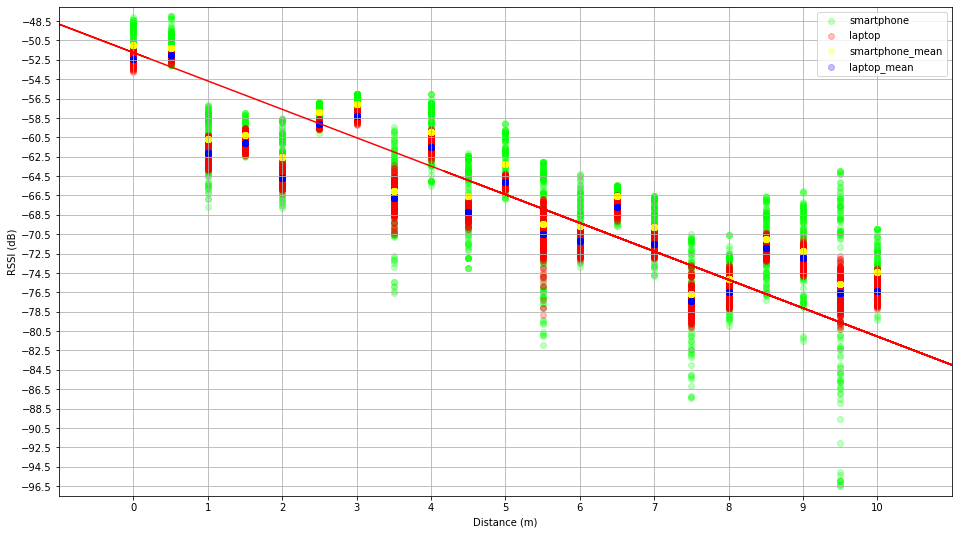

[[-0.34121982]]
[-17.65688091]


In [10]:
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.scatter(df_smartphone.distance, df_smartphone.rolling_mean_rssi,c='#00ff003f', label='smartphone')
ax1.scatter(df_laptop.distance, df_laptop.rolling_mean_rssi, c='#ff00003f', label='laptop')

ax1.scatter(df_smartphone.distance, df_smartphone.rssi_mean,c='#ffff003f', label='smartphone_mean')
ax1.scatter(df_laptop.distance, df_laptop.rssi_mean,c='#0000ff3f', label='laptop_mean')

X = df_all['rolling_mean_rssi'].values.reshape(-1,1)
y = df_all['distance'].values.reshape(-1,1)

lreg = LinearRegression().fit(X, y)
y_pred = lreg.predict(X)
plt.plot(y_pred, X, color='red')

#wlreg = LinearRegression().fit(X, y, df_all['weight'])
#wy_pred = wlreg.predict(X)
#plt.plot(wy_pred, X, color='blue')

plt.xlim(min(y)-1, max(y)+1)
plt.ylim(min(X)-1, max(X)+1)
plt.xticks(np.arange(min(y), max(y)+1, 1.0))
plt.yticks(np.arange(min(X), max(X)+1, 2.0))
plt.grid(True)
plt.legend(loc='upper right');
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dB)')
plt.show()

#For retrieving the slope:
print(lreg.coef_)
#To retrieve the intercept:
print(lreg.intercept_)